<a href="https://colab.research.google.com/github/Catarinatorres/spotify_unidade2/blob/main/Spotify_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Redes - UFRN
Exercício Unidade 2

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install matplotlib==3.1.3

In [ ]:
!pip install nxviz=='0.6.3'

#1. Import libraries

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import count
import json 
import matplotlib.pyplot as plt
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.patches as mpatches
import seaborn as sns


#2. Download the dataset and prepare the data

In [ ]:
#download the dataset
!gdown https://drive.google.com/u/0/uc?id=1caGQdAEo4iEEKYyCQd_hSXb5bfsasIKr&export=download

data = json.load(open('mpd.slice.549000-549999.json'))

#just colect the useful data
tamanho_playlists = len(data['playlists'])
num_playlist = []
num_tracks = []
artista = []
number = []
weight = []

for i in range(0, tamanho_playlists):
  z = len(data['playlists'][i]['tracks'])
  number.append(str(i))
  for l in range(0, z):
    num_playlist.append(i)
    num_tracks.append(l)
    artista.append(data['playlists'][i]['tracks'][l]['artist_name'])
    weight.append(1)

df = pd.DataFrame([number, num_playlist, num_tracks, artista, weight]).T
df.columns = ['number','num_playlist', 'num_tracks','artista', 'weight']
df['artista'] = df['artista'].astype(str).str.replace('\$\$',' x')

# as we are using a big dataset, we decided limit them by the playlists numbers, to make easer understand the analisys
# but you can change them adding or removing playlists
max_playlist = 10
df_mask=df['num_playlist']<=max_playlist
df = df[df_mask]

In [4]:
df1 = df
tam = len(df1.num_playlist)
print(tam)
artista_prox = []
z=0
x_playlist = 0
for i in range(0, tam):
  #print(i)
  z = z+1
  if z >= tam:
    artista_prox.append("")
  else:
    artista_prox.append(df1.artista[z])

df1['prox_artista'] = artista_prox
remover = []
m = 0
for l in range(0, max_playlist+1):
  m = len(df.loc[df1['num_playlist']==l]) + m
  remover.append(m-1)

for k in range(len(remover)-1,-1, -1):
  df1=df1.drop(df.index[remover[k]])

682


#2.1 Create the network

In [5]:
#create the network
MG = nx.from_pandas_edgelist(
    df1,
    'artista',
    'prox_artista',
     edge_attr='weight',     
    create_using=nx.MultiGraph()
)

# create weighted graph from MG
G = nx.Graph()
for u,v,data in MG.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['w'] += w
    else:
        G.add_edge(u, v, w=w)
# Export to graphml
nx.write_graphml(G, 'spotify.graphml')

#3. Data analisys

#3.1 Run the graphml create on step 2.1

In [6]:
# source: /content/spotify.graphml
g = nx.read_graphml('spotify.graphml')


#3.2 Plot the network

Some playlists could be disconnected. In this case, we are working just with ten playlists (number 0, 1, 2, 3). When we plot the network, we can see the disconnected node. This is important in case of the number of playlists were different from the number of plyalists in the network plotted latter.

In [ ]:
pos=nx.spring_layout(g, k=0.2)
edge_labels=dict([((u,v,),d['w'])
                 for u,v,d in g.edges(data=True)])
nx.draw_networkx_nodes(g, pos, node_size=200)
nx.draw_networkx_edges(g, pos)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10, font_color='black')

#3.3 Plot 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# as some playlists are disconnected, is necessary to make them connected, using subgraphs
# this code will collect the largest component of this network and create a giant subgraph 

try:
  # color of nodes based on eccentricity
  color = list(dict(nx.eccentricity(g)).values())
except:
  comps=sorted(nx.connected_components(g),
               key=len, reverse=True)
  nodes_in_giant_comp = comps[0]
  g = nx.subgraph(g, nodes_in_giant_comp)
  # color of nodes based on eccentricity
  color = list(dict(nx.eccentricity(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos, 
                       alpha=1, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color, 
                 cmap=plt.cm.jet,ax=ax)

# draw labels
#nx.draw_networkx_labels(g, pos=pos, font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eccentricity.png', transparent=True,dpi=400)
plt.show()


In [ ]:
print([k for k,v in nx.betweenness_centrality(g).items()])



```
# Isto está formatado como código
```

The maximum distance between two nodes is defined as eccentricity, in this case, the eccentricity of the network is 6. Observe that the most distance between nodes launches from singers in playlist 1 (Destini's Child, Beyoncé, Jay-Z, Lady Gaga), passing by playlist 1 to JAY Z(possible this is the same Jay-Z, writte incorrectly), going to playlist 0 wich is conect to singers in playlist 2 and finishing in others singers in playlist 2.

In [ ]:
# the diameter of networks is the maximum eccentricy
print("Diameter of network (g): {}".format(nx.diameter(g)))
print(nx.eccentricity(g))
# whom are in the diamter
print([k for k,v in nx.eccentricity(g).items() if v == nx.diameter(g)])

In [11]:
# the periphery of a network is a set of all nodes whose eccentriciy is equals the diameter
nx.periphery(g)

['Steppenwolf', 'C-Trox', 'Family of the Year']

The playlist 0 is the network center, wich radius is equal to 3.

In [ ]:
# the center of a network is a set all nodes whose eccentricity equal the radius
nx.center(g)

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.png', transparent=True,dpi=300)
plt.show()

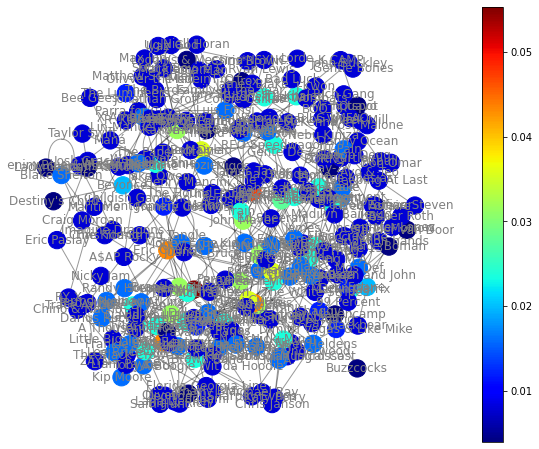

In [14]:
# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

In [15]:
nx.degree_centrality(g)

{'*NSYNC': 0.007905138339920948,
 '2 LIVE CREW': 0.007905138339920948,
 '99 Percent': 0.007905138339920948,
 'A Boogie Wit da Hoodie': 0.007905138339920948,
 'A Thousand Horses': 0.007905138339920948,
 'A$AP Rocky': 0.007905138339920948,
 'Aerosmith': 0.007905138339920948,
 'Afrojack': 0.015810276679841896,
 'Alice Boman': 0.003952569169960474,
 'American Authors': 0.003952569169960474,
 'Andrew Belle': 0.015810276679841896,
 'Angus & Julia Stone': 0.007905138339920948,
 'Ariana Grande': 0.007905138339920948,
 'Asher Roth': 0.007905138339920948,
 'Ashton Edminster': 0.007905138339920948,
 "Auli'i Cravalho": 0.003952569169960474,
 'Ayo & Teo': 0.007905138339920948,
 'B.o.B': 0.023715415019762844,
 'BOOTS': 0.007905138339920948,
 'Bad Luck': 0.007905138339920948,
 'Bad Suns': 0.007905138339920948,
 'Bee Gees': 0.007905138339920948,
 'Beenie Man': 0.007905138339920948,
 'Beyoncé': 0.01976284584980237,
 'Big & Rich': 0.007905138339920948,
 'Big Sean': 0.03162055335968379,
 'Billy Curringto

In [16]:
nx.closeness_centrality(g)

{'*NSYNC': 0.14221472737492974,
 '2 LIVE CREW': 0.1332280147446024,
 '99 Percent': 0.1465816917728853,
 'A Boogie Wit da Hoodie': 0.11077057793345009,
 'A Thousand Horses': 0.14465408805031446,
 'A$AP Rocky': 0.14237478897017444,
 'Aerosmith': 0.16799468791500663,
 'Afrojack': 0.14988151658767773,
 'Alice Boman': 0.07696988135077579,
 'American Authors': 0.11106233538191396,
 'Andrew Belle': 0.11411817771763645,
 'Angus & Julia Stone': 0.09353049907578559,
 'Ariana Grande': 0.1621794871794872,
 'Asher Roth': 0.1518607442977191,
 'Ashton Edminster': 0.07687632938316621,
 "Auli'i Cravalho": 0.14432401597261837,
 'Ayo & Teo': 0.14700755374782104,
 'B.o.B': 0.17484450587422254,
 'BOOTS': 0.07923582837456937,
 'Bad Luck': 0.08295081967213115,
 'Bad Suns': 0.08305975049244911,
 'Bee Gees': 0.14039955604883464,
 'Beenie Man': 0.1251855517070757,
 'Beyoncé': 0.16135204081632654,
 'Big & Rich': 0.1465816917728853,
 'Big Sean': 0.19312977099236642,
 'Billy Currington': 0.16799468791500663,
 'Bil

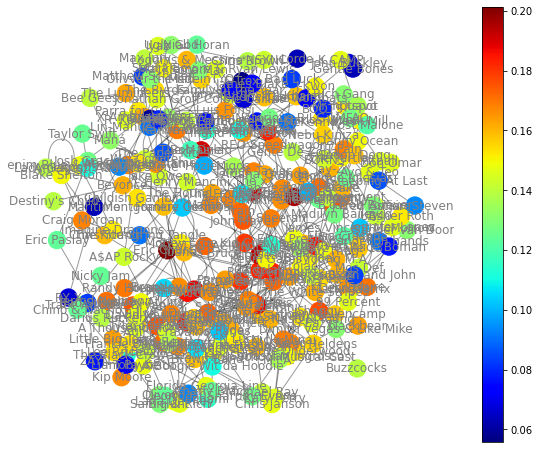

In [17]:
# the closeness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.closeness_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
plt.show()

In [18]:
nx.betweenness_centrality(g)

{'*NSYNC': 0.004889063662355589,
 '2 LIVE CREW': 0.0015214254344689127,
 '99 Percent': 0.005185693073891833,
 'A Boogie Wit da Hoodie': 1.5684798293493945e-05,
 'A Thousand Horses': 0.005287158780947597,
 'A$AP Rocky': 0.01084850277396862,
 'Aerosmith': 0.010086197812058917,
 'Afrojack': 0.018330300938996583,
 'Alice Boman': 0.0,
 'American Authors': 0.0,
 'Andrew Belle': 0.08432147562582346,
 'Angus & Julia Stone': 0.019386410690758516,
 'Ariana Grande': 0.005945930842411176,
 'Asher Roth': 0.0016616176554064758,
 'Ashton Edminster': 0.023150762281197064,
 "Auli'i Cravalho": 0.0,
 'Ayo & Teo': 0.0007081312981934102,
 'B.o.B': 0.07000622417853726,
 'BOOTS': 0.004078047556308426,
 'Bad Luck': 0.030710835058661144,
 'Bad Suns': 0.046489742141916056,
 'Bee Gees': 0.004354205250591476,
 'Beenie Man': 0.0002587991718426501,
 'Beyoncé': 0.015778907083254908,
 'Big & Rich': 8.713776829718858e-05,
 'Big Sean': 0.14502667564718272,
 'Billy Currington': 0.019803503757955077,
 'Billy Joel': 0.010

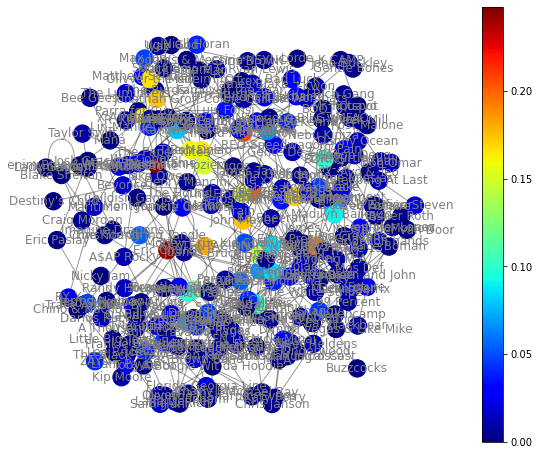

In [19]:
# the betwenness centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

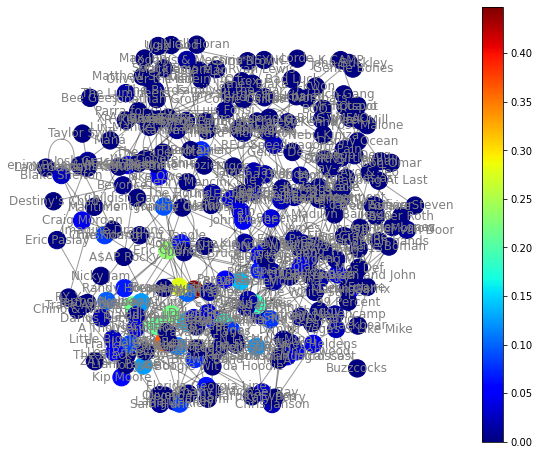

In [20]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(g, pos=pos,
                        font_color='gray', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

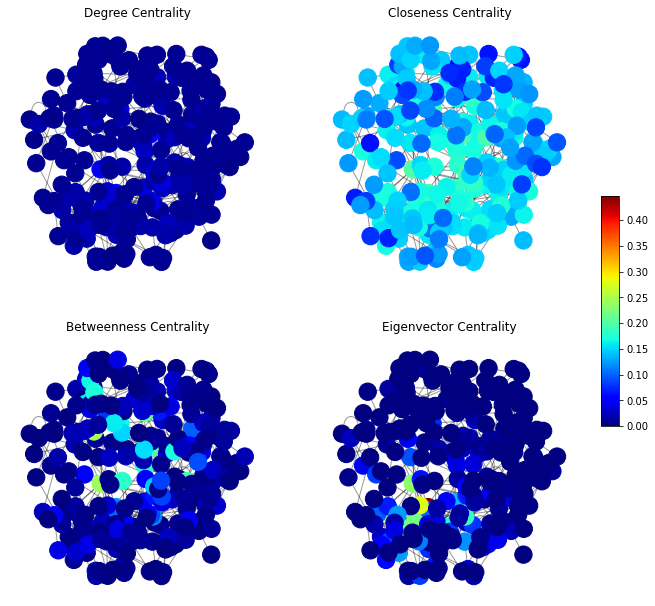

In [21]:
# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2,2,figsize=(10,8))

# max value of metrics 
max_centrality = max([max([v for k, v in nx.eigenvector_centrality(g).items()]),
                      max([v for k, v in nx.degree_centrality(g).items()]),
                      max([v for k, v in nx.closeness_centrality(g).items()]),
                      max([v for k, v in nx.betweenness_centrality(g).items()])])

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# color of nodes
color_degree = list(dict(nx.degree_centrality(g)).values())
color_closeness = list(dict(nx.closeness_centrality(g)).values())
color_betweenness = list(dict(nx.betweenness_centrality(g)).values())
color_eigenvector = list(dict(nx.eigenvector_centrality(g)).values())

# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,0])

# closeness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[0,1])

# betweenness centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,0])

# eigenvector centrality
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax[1,1])

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_closeness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_betweenness,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0])
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_eigenvector,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1])

# 
# draw labels
#
#nx.draw_networkx_labels(g, pos=pos,font_color='gray', ax=ax[0,0])
#nx.draw_networkx_labels(g, pos=pos,font_color='gray', ax=ax[0,1])
#nx.draw_networkx_labels(g, pos=pos,font_color='gray', ax=ax[1,0])
#nx.draw_networkx_labels(g, pos=pos,font_color='gray', ax=ax[1,1])

# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centrality")
ax[0,1].set_title("Closeness Centrality")
ax[1,0].set_title("Betweenness Centrality")
ax[1,1].set_title("Eigenvector Centrality")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)

plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

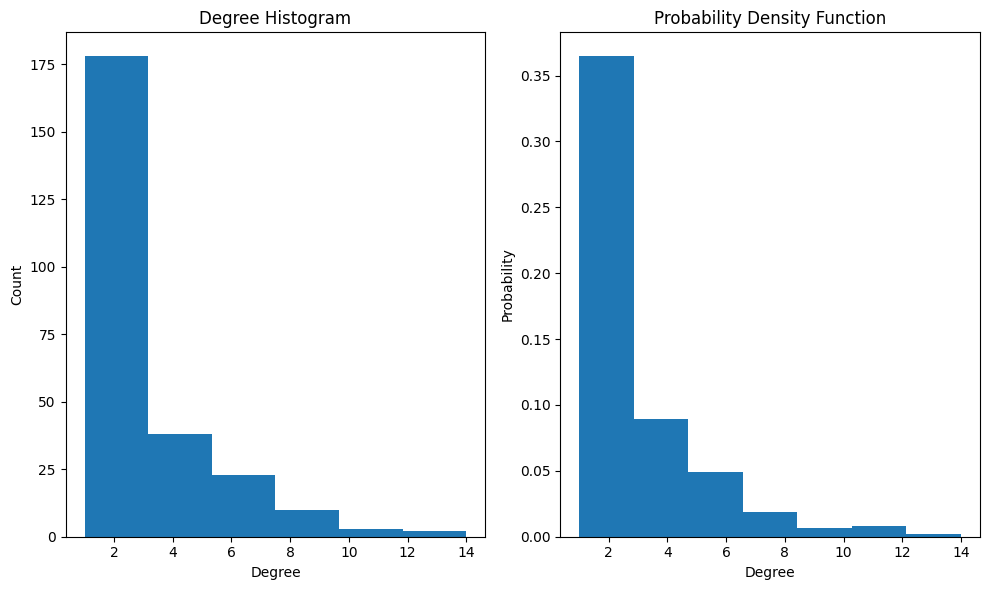

In [22]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(10,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=6)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

In [23]:
print(all_data)

(array([178.,  38.,  23.,  10.,   3.,   2.]), array([ 1.        ,  3.16666667,  5.33333333,  7.5       ,  9.66666667,
       11.83333333, 14.        ]), <BarContainer object of 6 artists>)


In [24]:
# print the width of each bin
print(all_data[1])

[ 1.          3.16666667  5.33333333  7.5         9.66666667 11.83333333
 14.        ]


In [25]:
# calc the width of each bin using numpy
# diff calc the difference between two positions in the array
bin_width = np.diff(all_data[1])
bin_width

array([2.16666667, 2.16666667, 2.16666667, 2.16666667, 2.16666667,
       2.16666667])

In [26]:
# total number of elements in array
all_data[0].sum()

254.0

In [27]:
# probability density function for each bin
# please check the right figure above and compare the results
all_data[0]/(all_data[0].sum() * bin_width)

array([0.32344034, 0.06904906, 0.04179285, 0.01817081, 0.00545124,
       0.00363416])

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

In [ ]:
plt.style.use("ggplot")

# Another way to visualize the cumulative distribution
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

In [ ]:
#
# insighs
# cdf(1) - almore 40% of vertices has degree 1
# cdf(2) P(degree <= 2) - 50% of vertices has at least degree 2 or less
# cdf(6) P(degree <= 6) - more than 95% of vertices has at least degree 6 or less
ecdf_degree(g)